<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_IA/blob/main/08_deep_learning/examen_final_q_11_RadioEncoder_Incomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nous voulons uitiliser l'IA génmérative pour simuler diverses formed de boutons de radio (stop, pause, play, avancer, reculer)

1. Importation des packages utiles

In [2]:
import numpy as np
from numpy import asarray
from numpy import unique
from numpy import argmax
from numpy import sqrt
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras import layers, models, datasets, callbacks, metrics
import tensorflow.keras.backend as K

2. Importer les données brutes

NOTE: on doit d'abord télécharger le fichier RadioCommandsData.csv sur le site web du cours dans la section "Contenu et activités / Séance en direct 6 - CNN et vision informatique

In [3]:
df = read_csv('https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/RadioCommandsData.csv')
print(len(df))
df.head(10)

330


,ID,Label,CenterX,CenterY,Height,Width,X1,X2,X3,X4,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
0,1,0,0.142857,0.214286,0.428571,0.285714,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0.285714,0.214286,0.428571,0.285714,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0.428571,0.214286,0.428571,0.285714,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0.571429,0.214286,0.428571,0.285714,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0.714286,0.214286,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,0,0.857143,0.214286,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0.142857,0.357143,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,0,0.285714,0.357143,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,0,0.428571,0.357143,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,0,0.571429,0.357143,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


3. Reformatter les X en images au format 8x8x1 (teintes de gris)

In [4]:
X_flat = np.array(df)
X_flat = X_flat[:,6:]
X_flat = X_flat.astype(np.float32)

X_complete = np.reshape(X_flat,(330,8,8,1))
print(X_complete.shape)

(330, 8, 8, 1)


4. Obtenir les labels (y) des images

NOTE: 0: pause, 1: stop, 2: play, 3: backward, 4: forward

In [5]:
y_complete = np.array(df)[:,1]

y_complete[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

5. Diviser les données en train et test data

In [6]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_complete, y_complete, test_size=0.33)
print(X_train_full.shape, X_test.shape, y_train_full.shape, y_test.shape)

(221, 8, 8, 1) (109, 8, 8, 1) (221,) (109,)


6. Conserver une portion des données en validation

In [7]:
X_train, y_train = X_train_full[:-50], y_train_full[:-50]
X_valid, y_valid = X_train_full[-50:], y_train_full[-50:]
print(X_train_full.shape, X_test.shape,X_train.shape,X_valid.shape, y_train_full.shape, y_test.shape,y_train.shape,y_valid.shape)

(221, 8, 8, 1) (109, 8, 8, 1) (171, 8, 8, 1) (50, 8, 8, 1) (221,) (109,) (171,) (50,)


7. Modifier la "shape" des données pour se conformer aux entrées attendus de Keras et storer la shape des images d'input dans une variable nommée in_shape (pour le première couche d'entrée)

In [8]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1))

in_shape = X_train.shape[1:]
print(in_shape)

(8, 8, 1)


8. Visualiser quelques images

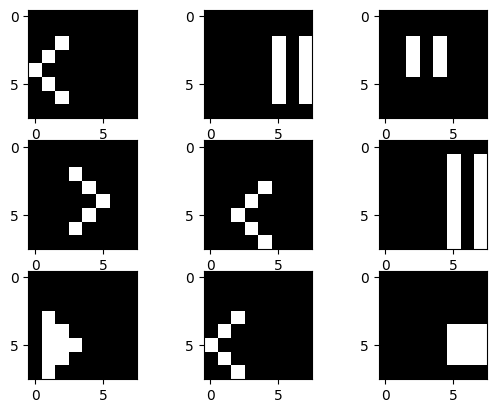

In [9]:
from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

9. Storer le nombre de clasees possibles (5 dans ce cas-ci, car 0, 1, 2, 3, 4) dans la variable n_classes

In [10]:
n_classes = len(unique(y_train))
print(n_classes)

5


10. Bâtir l'IA générative ... rendu ici ...

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

# Define the VAE architecture
def build_vae(input_shape, latent_dim):
    # Encoder
    encoder_input = Input(shape=input_shape)
    x = Dense(128, activation='relu')(encoder_input)
    x = Dense(64, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(64, activation='relu')(decoder_input)
    x = Dense(128, activation='relu')(x)
    decoder_output = Dense(input_shape[0], activation='sigmoid')(x)

    # Models
    encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(decoder_input, decoder_output, name='decoder')
    vae_output = decoder(encoder(encoder_input)[2])
    vae = Model(encoder_input, vae_output, name='vae')

    # VAE loss
    reconstruction_loss = mse(encoder_input, vae_output)
    reconstruction_loss *= input_shape[0]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    return vae, encoder, decoder

# Build the VAE model
input_shape = (64, 1)  # Adjust this to your input shape
latent_dim = 2  # Choose an appropriate latent dimension
vae, encoder, decoder = build_vae(input_shape, latent_dim)

# Compile the VAE model
vae.compile(optimizer='adam')

# Print model summary
vae.summary()


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 64, 1)]              0         []                            
                                                                                                  
 encoder (Functional)        [(None, 64, 2),              8772      ['input_5[0][0]']             
                              (None, 64, 2),                                                      
                              (None, 64, 2)]                                                      
                                                                                                  
 decoder (Functional)        (None, 64)                   16768     ['encoder[0][2]']             
                                                                                                

In [ ]:
### Generate images

1/1 [==============================] - 0s 258ms/step


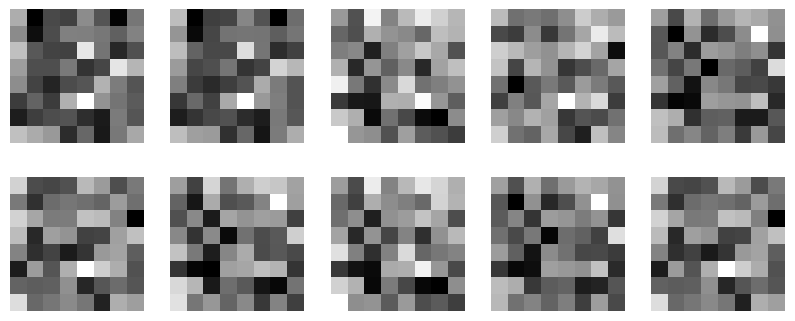

In [14]:
# Generate random samples from the latent space
latent_samples = np.random.normal(size=(10, latent_dim))

# Use the decoder to generate images from the latent samples
generated_images = decoder.predict(latent_samples)

# Plot the generated images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i].reshape(8, 8), cmap='gray')
    plt.axis('off')

plt.show()
